In [1]:
import torch
from matplotlib.pylab import plt
import math
torch.set_default_device('cuda')

In [2]:
N = 128
M = 512

In [3]:
W1 = []
W2 = []
for i in range(5):
    W1.append(torch.randn([N,M]))
    W2.append(W1[i] +  + torch.randn([N,M]) / 10)

### Single Experiment

In [4]:
def exp(params, forward):
    
    for e in range(5):
        optimiser = torch.optim.Adam(params, lr = 1e-5)
        criteria = torch.nn.MSELoss()

        losses = []
        iterations = []

        for i in range(100001):

            optimiser.zero_grad()
            loss = criteria(W2[e], forward(params, W1[e]))
            loss.backward()
            optimiser.step()

            if i%10==0:
                losses.append(float(loss))
                iterations.append(i)

        plt.plot(iterations, losses)
        plt.xscale('log')
        plt.yscale('log')
        plt.show()

        print(loss)

### Experiment for ranks

In [5]:
def rank_exp(dim, forward, init):
    # dim is dimension of (AB)
    
    for exp in range(5):
        all_losses = []
        ranks = []

        R = 1
        while R<=min(dim[0], dim[1]):

            print('#' * 5 + ' Rank ' + str(R) + '#' * 5)

            A1 = torch.nn.Parameter(torch.zeros([dim[0],R]))
            B1 = torch.nn.Parameter(torch.zeros([R,dim[1]]))

            params = [A1, B1]
            init(params)

            optimiser = torch.optim.Adam(params, lr = 1e-5)
            criteria = torch.nn.MSELoss()

            losses = []
            iterations = []

            for i in range(100001):

                optimiser.zero_grad()
                loss = criteria(W2[exp], forward(params, W1[exp]))
                loss.backward()
                optimiser.step()

                if i%10==0:
                    iterations.append(i)
                    losses.append(float(loss))

            print(loss)
            plt.plot(iterations, losses, label = 'Rank ' + str(R))

            R=R*2

        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        plt.show()

### Initialise

In [6]:
def init_lora_matrices(A, B):
    with torch.no_grad():
        torch.nn.init.kaiming_normal_(A)
        torch.nn.init.zeros_(B)
        
def init_mult_lora_matrices(A, B):
    torch.nn.init.kaiming_normal_(A)
    with torch.no_grad():
        A_t = A.t()
        B.copy_(torch.matmul(torch.inverse(torch.matmul(A_t, A)), A_t))
        
def init_shift_lora_matrices(A, B):
    with torch.no_grad():
        torch.nn.init.kaiming_normal_(A)
        torch.nn.init.zeros_(B)
        B[0][0] = 1
        A[:, 0] = 1

### Shift

In [7]:
shift_indices = None

def set_shift_indices(r, c):
    global shift_indices
    shift_indices = torch.zeros([r,c], dtype=torch.int64)
    for i in range(r):
        for j in range(c):
            shift_indices[i][j] = (j - i)%c

def shift(M):
    n_rows, n_cols = M.shape
    global shift_indices
    return torch.gather(M, 1, shift_indices)

### Pre Mult Full

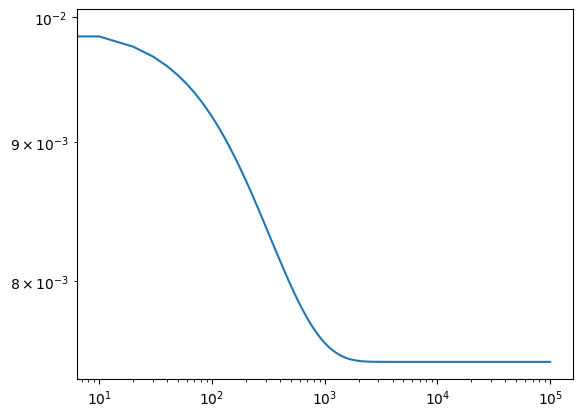

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


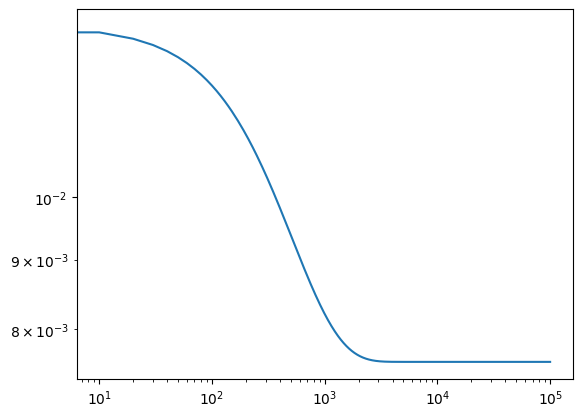

tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)


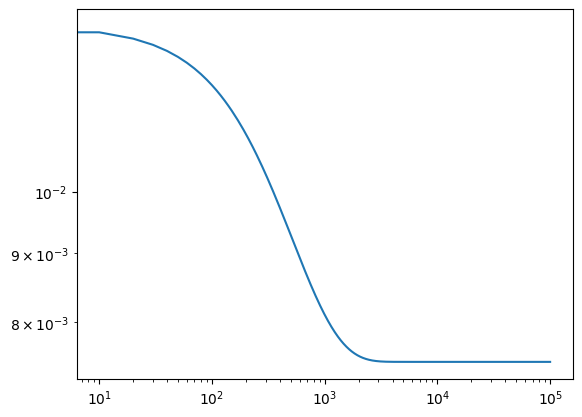

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


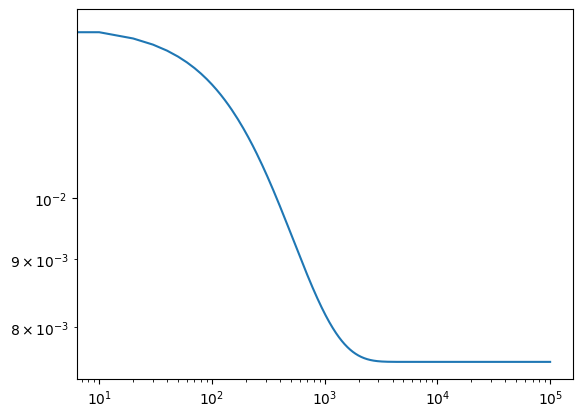

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


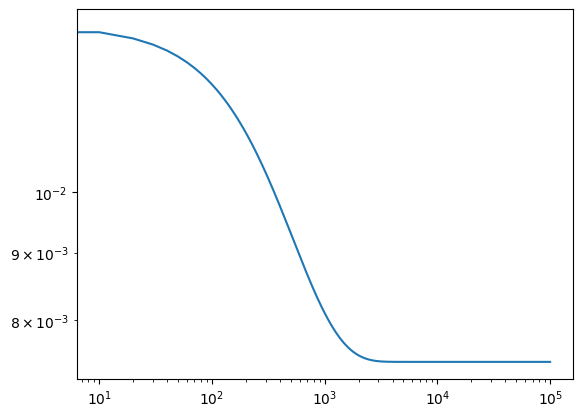

tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)


In [8]:
A_pre = torch.nn.Parameter(torch.eye(N))

def forward(params, W1):
    return params[0] @ W1

params = [A_pre]
exp(params, forward)

### Post Mult Full

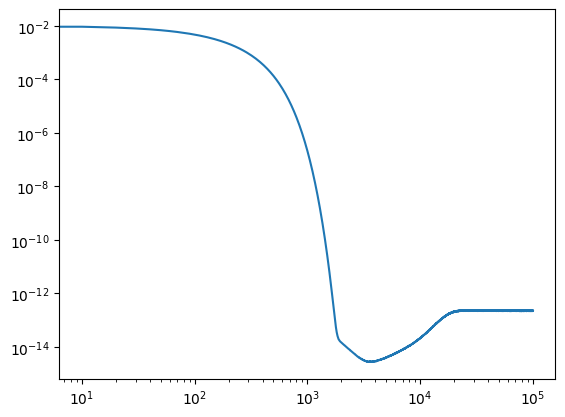

tensor(2.2247e-13, device='cuda:0', grad_fn=<MseLossBackward0>)


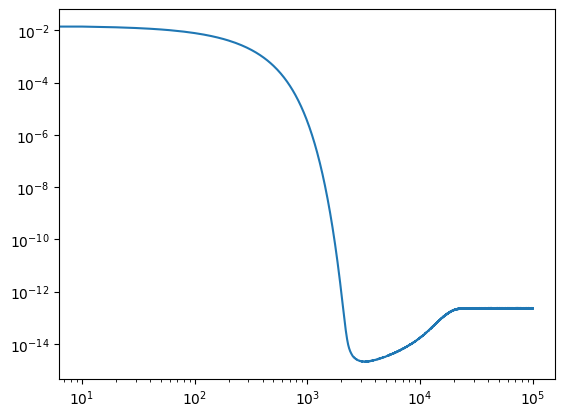

tensor(2.3356e-13, device='cuda:0', grad_fn=<MseLossBackward0>)


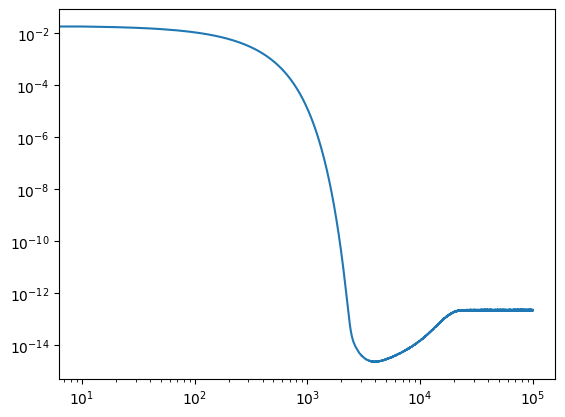

tensor(2.2582e-13, device='cuda:0', grad_fn=<MseLossBackward0>)


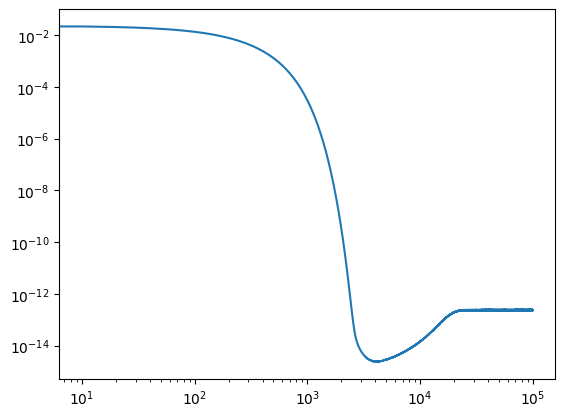

tensor(2.3748e-13, device='cuda:0', grad_fn=<MseLossBackward0>)


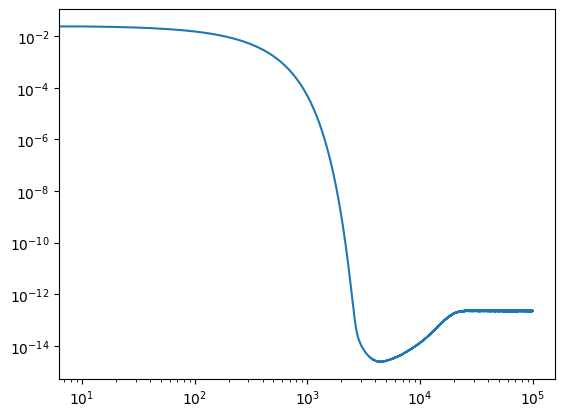

tensor(2.2449e-13, device='cuda:0', grad_fn=<MseLossBackward0>)


In [9]:
A_post = torch.nn.Parameter(torch.eye(M))

def forward(params, W1):
    return W1 @ params[0]

params = [A_post]
exp(params, forward)

### Mult Pre r

##### Rank 1#####
tensor(1.0015, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9875, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9548, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8897, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7743, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5844, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.3011, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


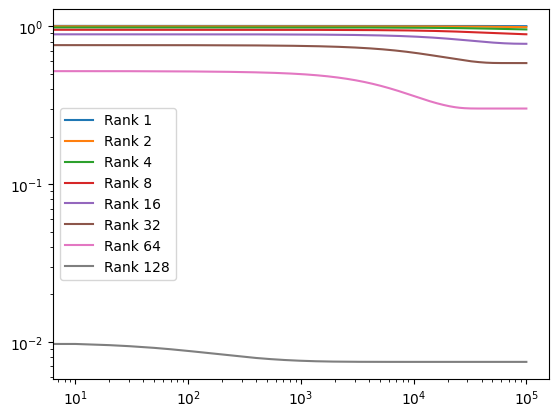

##### Rank 1#####
tensor(0.9973, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9810, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9495, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8821, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7667, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5771, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2959, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)


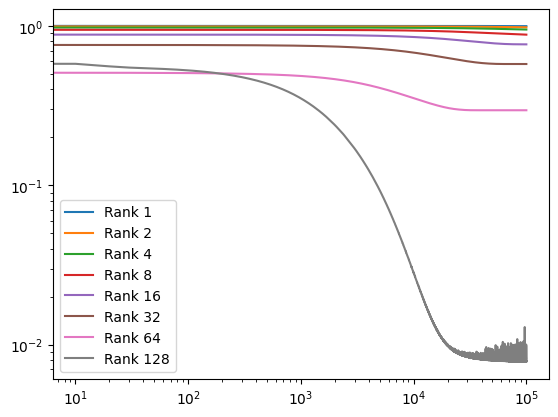

##### Rank 1#####
tensor(0.9993, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9843, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9534, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8879, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7715, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5797, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2976, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


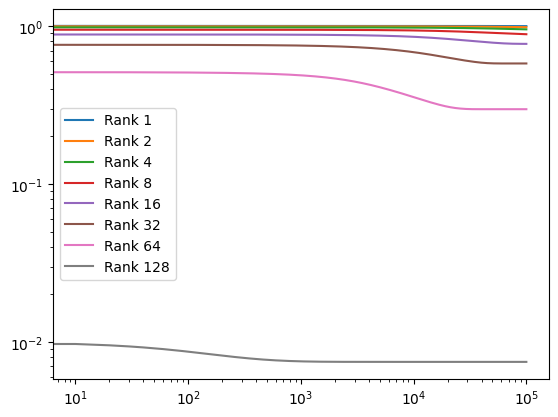

##### Rank 1#####
tensor(1.0044, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9889, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9559, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8915, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7765, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5835, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2999, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


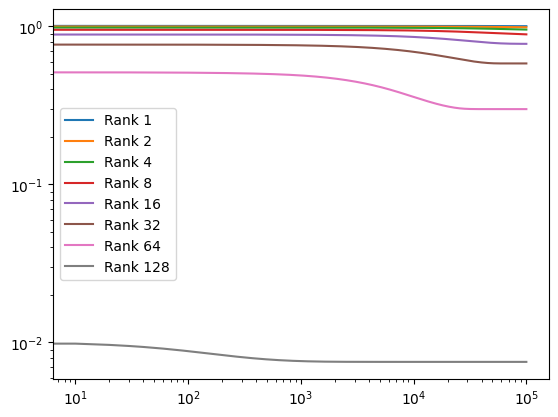

##### Rank 1#####
tensor(0.9920, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9778, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9446, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8807, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7657, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5763, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2961, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)


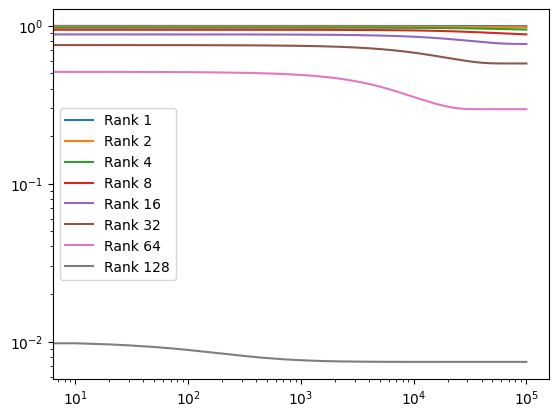

In [10]:
def forward(params, W1):
    return params[0] @ (params[1] @ W1)

def init(params):
    init_mult_lora_matrices(params[0], params[1])

set_shift_indices(N,N)
rank_exp([N,N], forward, init)

### Mult Post r

##### Rank 1#####
tensor(0.9975, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9810, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9482, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8862, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7733, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5826, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2974, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(4.6893e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.1027e-09, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(6.8418e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


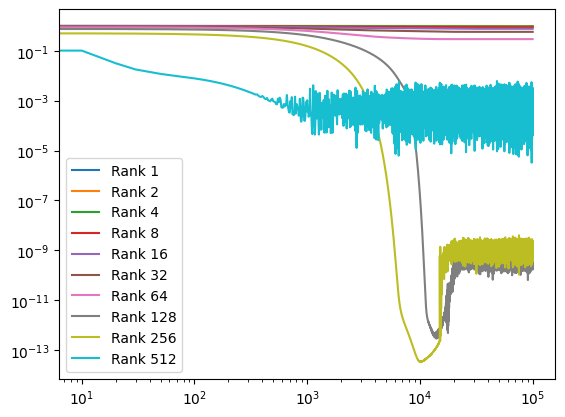

##### Rank 1#####
tensor(0.9922, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9743, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9404, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8784, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7657, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5753, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2922, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(2.5401e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.2820e-09, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)


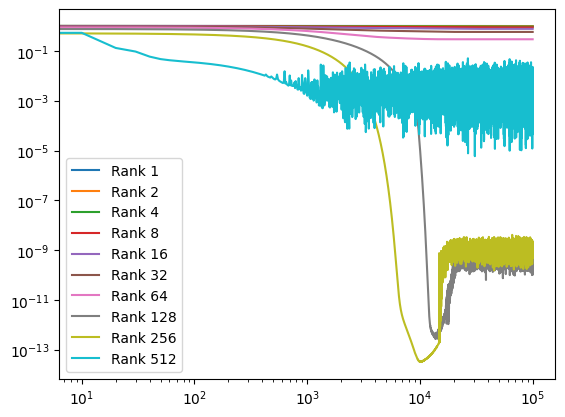

##### Rank 1#####
tensor(0.9950, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9777, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9448, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8833, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7706, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5778, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2939, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.5652e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(7.3057e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


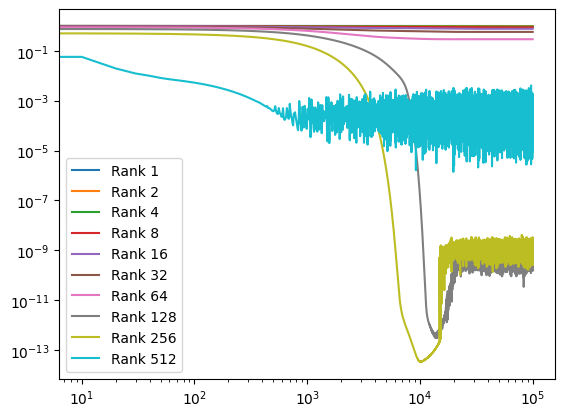

##### Rank 1#####
tensor(1.0005, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9827, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9493, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8877, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7756, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5816, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2961, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.7941e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.0254e-09, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


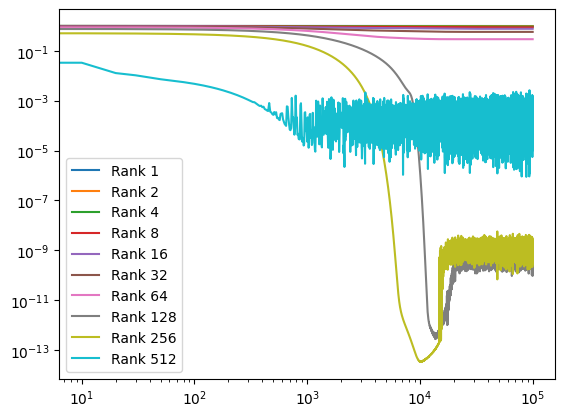

##### Rank 1#####
tensor(0.9873, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9707, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9366, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8750, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7648, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5744, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2924, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(2.7403e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(3.0247e-09, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(98221.2188, device='cuda:0', grad_fn=<MseLossBackward0>)


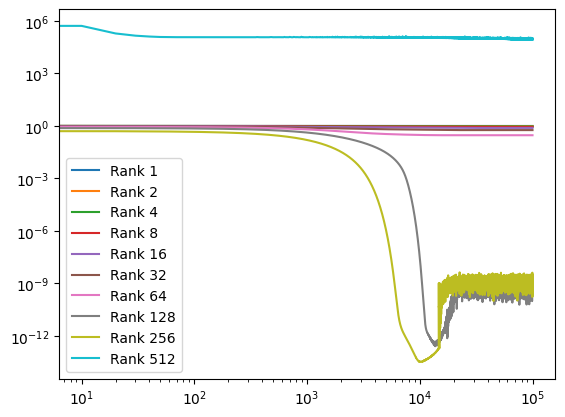

In [11]:
def forward(params, W1):
    return (W1 @ params[0]) @ params[1]

def init(params):
    init_mult_lora_matrices(params[0], params[1])

set_shift_indices(M,M)
rank_exp([M,M], forward, init)

### LoRA

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.6643e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


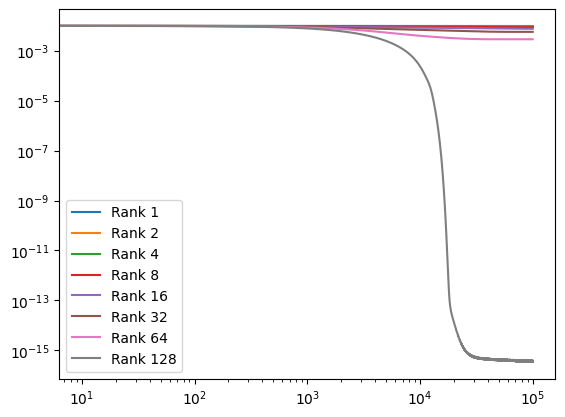

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.6665e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


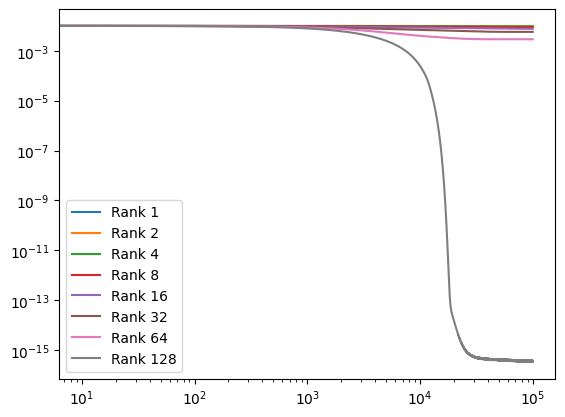

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.5548e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


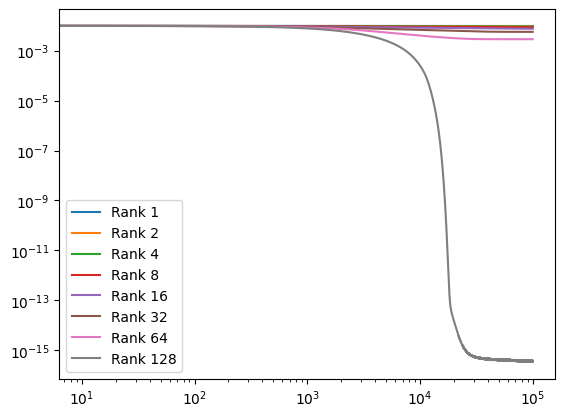

##### Rank 1#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.6030e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


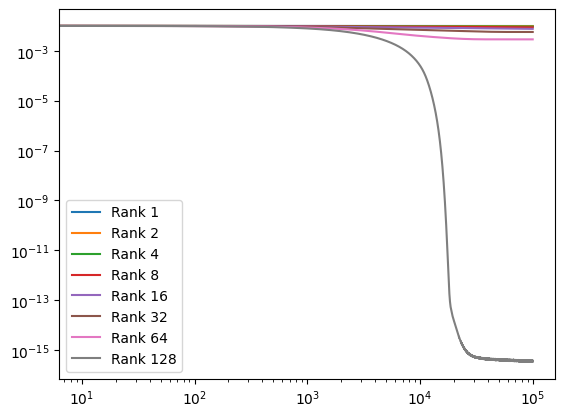

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.6492e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


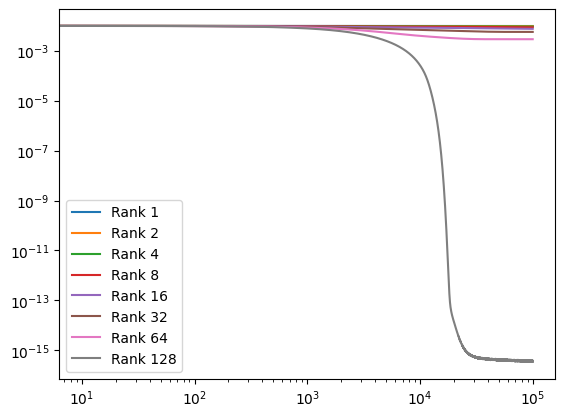

In [12]:
def forward(params, W1):
    return W1 + params[0] @ params[1]

def init(params):
    init_lora_matrices(params[0], params[1])

rank_exp([N,M], forward, init)

### LoRA - shift

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.7271e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


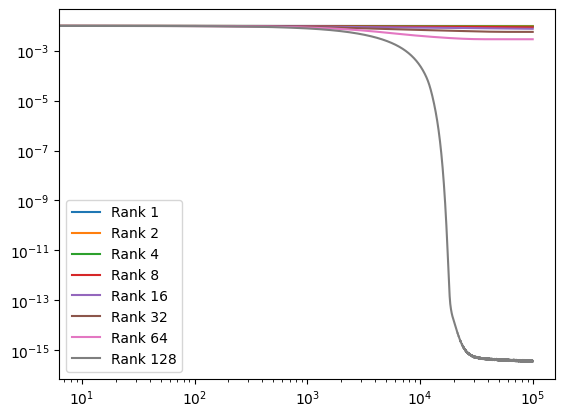

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.5438e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


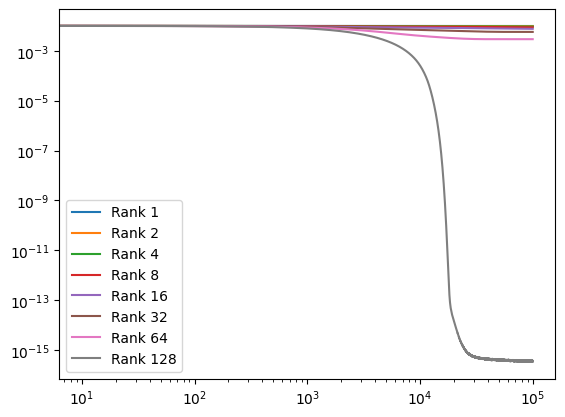

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.7170e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


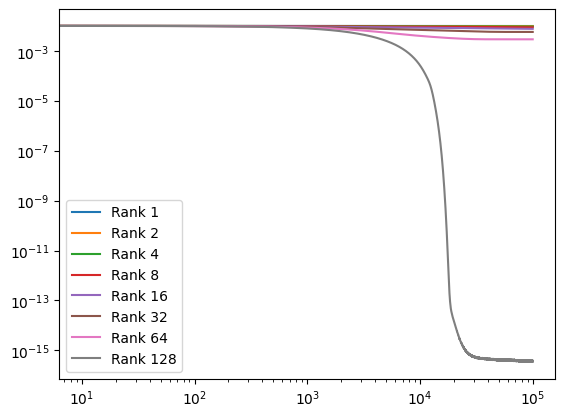

##### Rank 1#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.6298e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


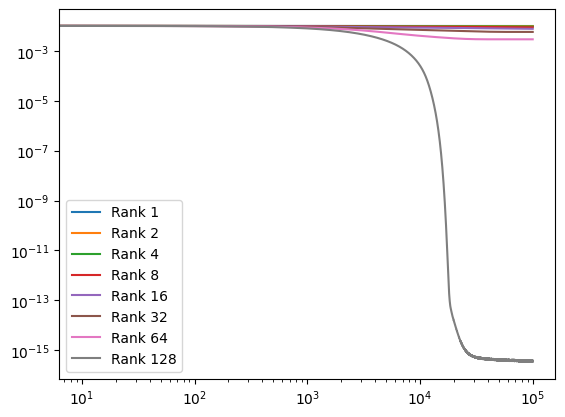

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(3.5563e-16, device='cuda:0', grad_fn=<MseLossBackward0>)


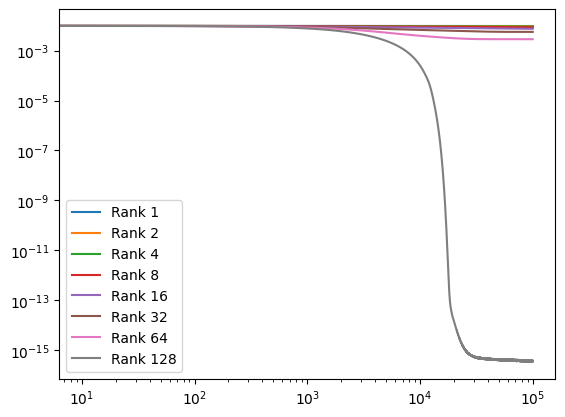

In [13]:
def forward(params, W1):
    return W1 + shift(params[0] @ params[1])

def init(params):
    init_lora_matrices(params[0], params[1])

set_shift_indices(N,M)
rank_exp([N,M], forward, init)

### Pre Mult r - shift

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


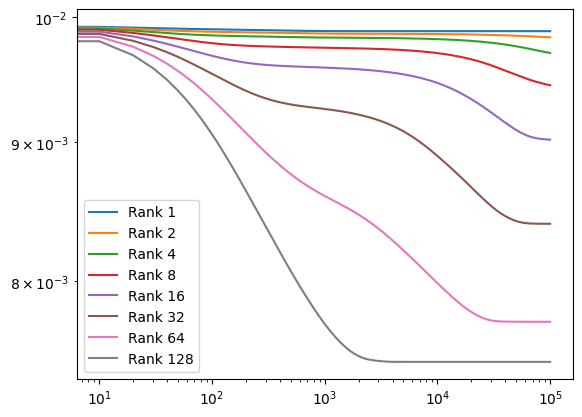

##### Rank 1#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)


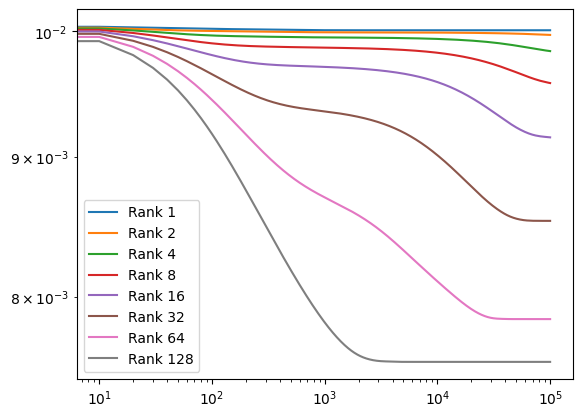

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


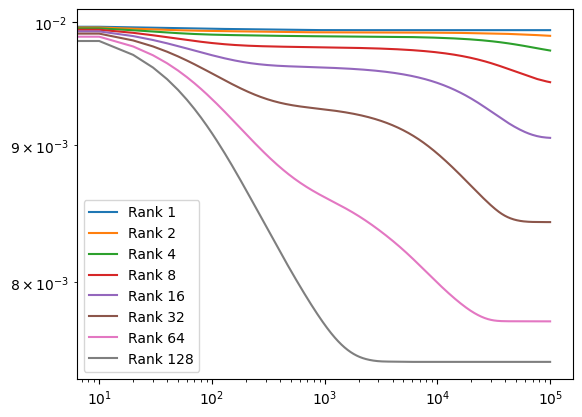

##### Rank 1#####
tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


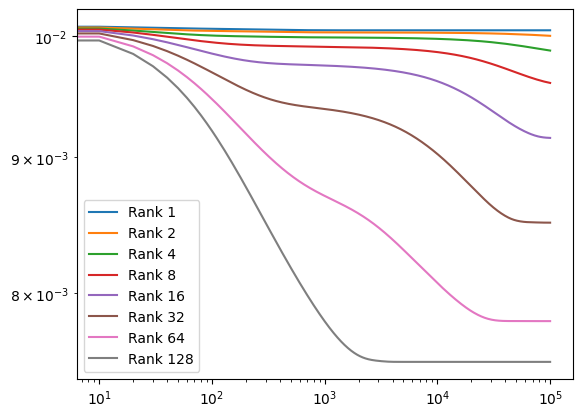

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)


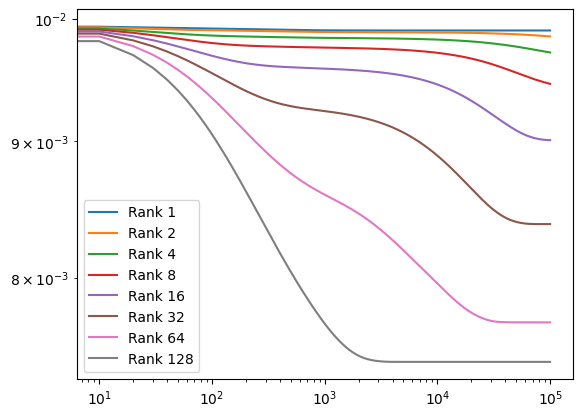

In [14]:
def forward(params, W1):
    return shift(params[0] @ params[1]) @ W1

def init(params):
    init_shift_lora_matrices(params[0], params[1])

set_shift_indices(N,N)
rank_exp([N,N], forward, init)

### Post Mult r - shift

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.2064e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(6.0168e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.2146e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(3.9838e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


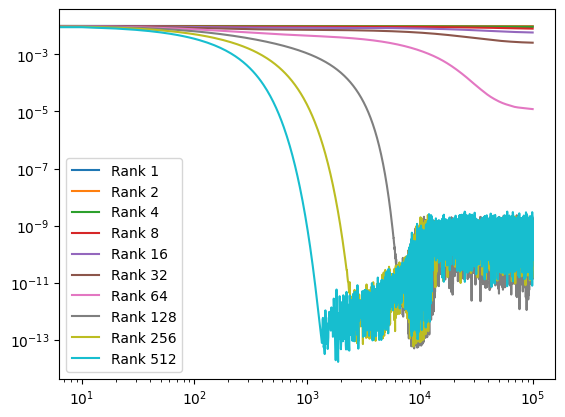

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.2296e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.8472e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.3629e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(3.4734e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


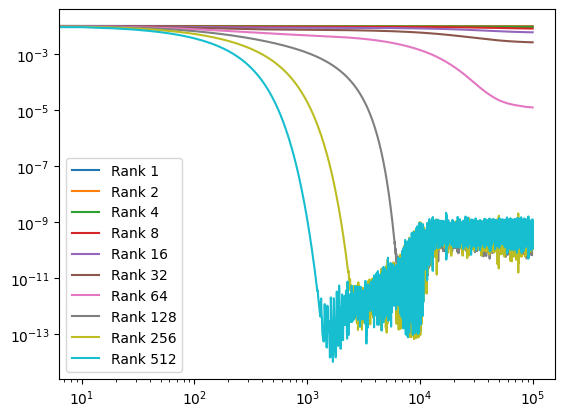

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.2393e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(6.0729e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(8.2061e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(3.0735e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


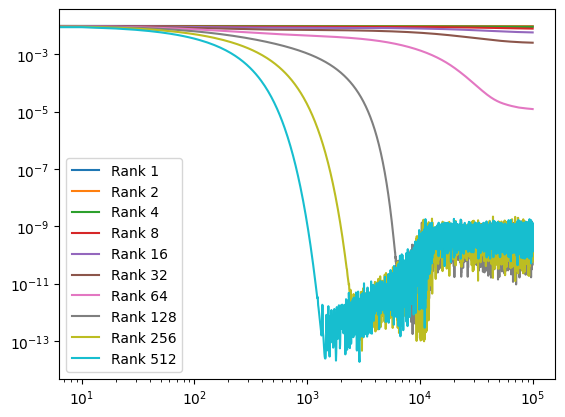

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.1967e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(2.9015e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(2.4891e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(1.1584e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


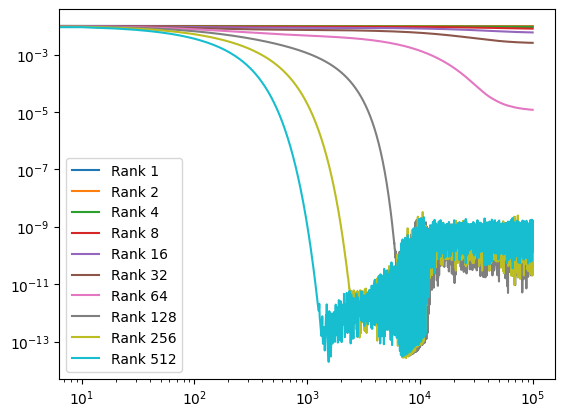

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.2224e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(2.6065e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(4.3614e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(5.7101e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


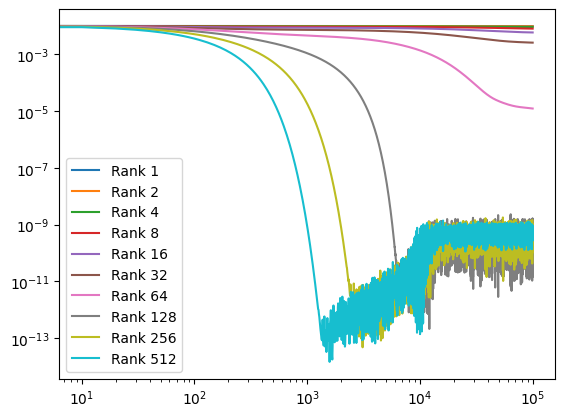

In [15]:
def forward(params, W1):
    return W1 @ shift(params[0] @ params[1])

def init(params):
    init_shift_lora_matrices(params[0], params[1])

set_shift_indices(M,M)
rank_exp([M,M], forward, init)